In [1]:
import numpy as np
import pandas as pd

In [2]:
def load_keras_model(path):
    from keras.models import model_from_json
    model = model_from_json(open(path + '.json').read())
    model.load_weights(path + '.h5')
    return model

In [3]:
model = load_keras_model("/cellar/users/aklie/projects/ML4GLand/use_cases/deAlmeida22/models/zenodo/DeepSTARR.model")

2023-05-06 16:49:53.702704: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [4]:
def get_fastas_from_file(fasta_path, as_dict=False,
                         uppercase=False, stop_at=None):
    fastas = []
    seq = None
    header = None
    for r in (gzip.open(fasta_path) if fasta_path.endswith(".gz") else open(fasta_path)):
        if type(r) is bytes:
            r = r.decode("utf-8")
        r = r.strip()
        if r.startswith(">"):
            if seq != None and header != None:
                fastas.append([header, seq])
                if stop_at != None and len(fastas) >= stop_at:
                    break
            seq = ""
            header = r[1:]
        else:
            if seq != None:
                seq += r.upper() if uppercase else r
            else:
                seq = r.upper() if uppercase else r
    # append last fasta read by method
    if stop_at != None and len(fastas) < stop_at:
        fastas.append([header, seq])
    elif stop_at == None:
        fastas.append([header, seq])
    if as_dict:
        return {h: s for h, s in fastas}

    return pd.DataFrame({'location': [e[0] for e in fastas], 'sequence': [e[1] for e in fastas]})

In [5]:
fasta_df = get_fastas_from_file("/cellar/users/aklie/projects/ML4GLand/use_cases/deAlmeida22/data/Sequences_Test.fa")

In [6]:
def parse_alpha_to_seq(sequence):
    output = np.arange(len(sequence))
    for i in range(0, len(sequence)):
        snippet = sequence[i]
        if snippet == 'A':
            output[i] = 0
        elif snippet == 'C':
            output[i] = 1
        elif snippet == 'G':
            output[i] = 2
        elif snippet == 'T':
            output[i] = 3
        elif snippet == 'N':
            output[i] = -1
        else:
            raise AssertionError("Cannot handle snippet: " + snippet)
    return output

def to_categorical(y, nb_classes=None):
    '''Convert class vector (integers from 0 to nb_classes)
    to binary class matrix, for use with categorical_crossentropy
    '''
    y = np.asarray(y, dtype='int32')
    if not nb_classes:
        nb_classes = np.max(y) + 1
    Y = np.zeros((len(y), nb_classes))
    for i in range(len(y)):
        if y[i] != -1:
            Y[i, y[i]] = 1.
    return Y

def do_one_hot_encoding(sequence, seq_length, f=parse_alpha_to_seq):
    X = np.zeros((sequence.shape[0], seq_length, 4))
    for idx in range(0, len(sequence)):
        X[idx] = to_categorical(f(sequence[idx]), 4)
    return X

In [7]:
print(fasta_df.shape)


(41186, 2)


In [8]:
# length of first sequence
sequence_length = len(fasta_df.sequence.iloc[0])

In [9]:
# Convert sequence to one hot encoding matrix
seq_matrix = do_one_hot_encoding(fasta_df.sequence, sequence_length, parse_alpha_to_seq)

In [10]:
seq_matrix.shape

(41186, 249, 4)

In [11]:
preds = model.predict(seq_matrix)

2023-05-06 16:50:17.986501: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:116] None of the MLIR optimization passes are enabled (registered 2)
2023-05-06 16:50:18.002230: I tensorflow/core/platform/profile_utils/cpu_utils.cc:112] CPU Frequency: 2999820000 Hz


In [12]:
out_prediction = fasta_df
out_prediction['Predictions_dev'] = preds[0]
out_prediction['Predictions_hk'] = preds[1]

In [13]:
out_prediction

,location,sequence,Predictions_dev,Predictions_hk
0,chr2R_10574736_10574984_+_positive_peaks,AACATACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATA...,3.125947,1.372647
1,chr2R_10577049_10577297_+_positive_peaks,ATGCCTGTTGGCCTGCGTAAGGAGCTACCATCAACATCAGCATCGC...,1.031718,-0.204710
2,chr2R_10600762_10601010_+_positive_peaks,TGTCGCTCCCATTTCGTCAAATGTTGCGTGCTAATTCGCTTGCCTT...,3.004485,0.590989
3,chr2R_10601947_10602195_+_positive_peaks,TTGTTGTTGTTGTTGCTCTTGTTGCTGGTGATTTCCACAGGCTTAG...,1.330016,-0.001533
4,chr2R_10605176_10605424_+_positive_peaks,TGTATTGTTGGGTTCCCAATAATTGATTATAAACGAGTGGAAATTG...,2.289671,0.001859
...,...,...,...,...
41181,chr2R_21141601_21141849_-_negative,CGGGATTGTCTATTTAAGTCACTCAGCTCCCTTGCTATACCCAAGA...,-0.657735,-0.782753
41182,chr2R_21141901_21142149_-_negative,GCACTAGCTGAGTAACAGGTATTTGATCGTTGGGGAACTCTCGTTT...,-0.396862,-0.878068
41183,chr2R_21142401_21142649_-_negative,TGAAAGTGTGTGCGTTCTGTTCTCTGTACTTTTCGGTGTAAAAGTA...,0.018391,-0.527420
41184,chr2R_21142501_21142749_-_negative,GCGCCGTGTTAAACACAAGTTTTTTGGCGGAATGCCTATTTAATCT...,0.191093,-0.336408


In [14]:
targets = pd.read_csv("/cellar/users/aklie/projects/ML4GLand/use_cases/deAlmeida22/data/Sequences_activity_Test.txt", sep="\t")

In [15]:
out_prediction[["True_dev", "True_hk"]] = targets[['Dev_log2_enrichment_scaled', 'Hk_log2_enrichment_scaled']]

In [16]:
out_prediction

,location,sequence,Predictions_dev,Predictions_hk,True_dev,True_hk
0,chr2R_10574736_10574984_+_positive_peaks,AACATACCCTGCTCTAGCGTATTGCTTTTTAATTGGCAGAAAAATA...,3.125947,1.372647,2.019106,1.249387
1,chr2R_10577049_10577297_+_positive_peaks,ATGCCTGTTGGCCTGCGTAAGGAGCTACCATCAACATCAGCATCGC...,1.031718,-0.204710,1.225755,-0.182038
2,chr2R_10600762_10601010_+_positive_peaks,TGTCGCTCCCATTTCGTCAAATGTTGCGTGCTAATTCGCTTGCCTT...,3.004485,0.590989,2.062184,0.917304
3,chr2R_10601947_10602195_+_positive_peaks,TTGTTGTTGTTGTTGCTCTTGTTGCTGGTGATTTCCACAGGCTTAG...,1.330016,-0.001533,0.915108,0.137596
4,chr2R_10605176_10605424_+_positive_peaks,TGTATTGTTGGGTTCCCAATAATTGATTATAAACGAGTGGAAATTG...,2.289671,0.001859,2.946757,0.529130
...,...,...,...,...,...,...
41181,chr2R_21141601_21141849_-_negative,CGGGATTGTCTATTTAAGTCACTCAGCTCCCTTGCTATACCCAAGA...,-0.657735,-0.782753,-0.159378,-0.342474
41182,chr2R_21141901_21142149_-_negative,GCACTAGCTGAGTAACAGGTATTTGATCGTTGGGGAACTCTCGTTT...,-0.396862,-0.878068,-1.095283,0.449938
41183,chr2R_21142401_21142649_-_negative,TGAAAGTGTGTGCGTTCTGTTCTCTGTACTTTTCGGTGTAAAAGTA...,0.018391,-0.527420,0.219561,-1.255139
41184,chr2R_21142501_21142749_-_negative,GCGCCGTGTTAAACACAAGTTTTTTGGCGGAATGCCTATTTAATCT...,0.191093,-0.336408,0.524210,-1.089057


In [17]:
# plot the predictions in a scatter plot
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde

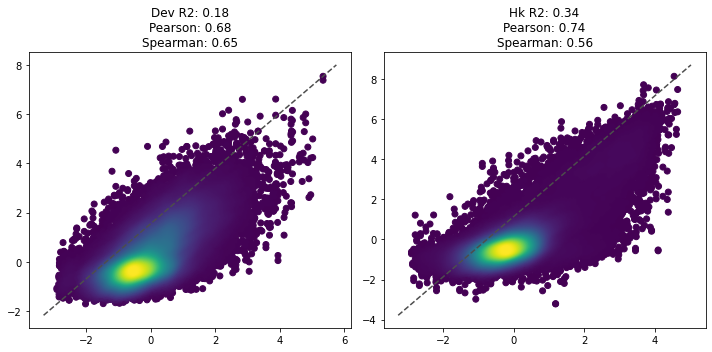

In [18]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

# Get point densities
x = out_prediction['True_dev']
y = out_prediction['Predictions_dev']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax[0].scatter(x, y, c=z)

# Get point densities
x = out_prediction['True_hk']
y = out_prediction['Predictions_hk']
xy = np.vstack([x,y])
z = gaussian_kde(xy)(xy)

# Sort the points by density, so that the densest points are plotted last
idx = z.argsort()
x, y, z = x[idx], y[idx], z[idx]

ax[1].scatter(x, y, c=z)

# Add metrics to the plots
from sklearn.metrics import r2_score
from scipy.stats import pearsonr, spearmanr

r2_dev = r2_score(out_prediction['True_dev'], out_prediction['Predictions_dev'])
r2_hk = r2_score(out_prediction['True_hk'], out_prediction['Predictions_hk'])

pearson_dev = pearsonr(out_prediction['True_dev'], out_prediction['Predictions_dev'])
pearson_hk = pearsonr(out_prediction['True_hk'], out_prediction['Predictions_hk'])

spearman_dev = spearmanr(out_prediction['True_dev'], out_prediction['Predictions_dev'])
spearman_hk = spearmanr(out_prediction['True_hk'], out_prediction['Predictions_hk'])

ax[0].set_title(f"Dev R2: {r2_dev:.2f}\nPearson: {pearson_dev[0]:.2f}\nSpearman: {spearman_dev[0]:.2f}")
ax[1].set_title(f"Hk R2: {r2_hk:.2f}\nPearson: {pearson_hk[0]:.2f}\nSpearman: {spearman_hk[0]:.2f}")

# Add a diagonal line to the plots
ax[0].plot(ax[0].get_xlim(), ax[0].get_ylim(), ls="--", c=".3")
ax[1].plot(ax[1].get_xlim(), ax[1].get_ylim(), ls="--", c=".3")

plt.tight_layout()
plt.show()

# Interpret

Again tried to make this work, seems to run into dependency hell

In [19]:
X = np.nan_to_num(seq_matrix) # Replace NaN with zero and infinity with large finite numbers
X_reshaped = X.reshape((X.shape[0], X.shape[1], X.shape[2]))

In [23]:
from deeplift.dinuc_shuffle import dinuc_shuffle

In [24]:
dinuc_shuffle_n=100

In [25]:
def dinuc_shuffle_several_times(list_containing_input_modes_for_an_example,
                                seed=1234):
  assert len(list_containing_input_modes_for_an_example)==1
  onehot_seq = list_containing_input_modes_for_an_example[0]
  rng = np.random.RandomState(seed)
  to_return = np.array([dinuc_shuffle(onehot_seq, rng=rng) for i in range(dinuc_shuffle_n)])
  return [to_return] #wrap in list for compatibility with multiple modes

In [26]:
# get hypothetical scores also
def combine_mult_and_diffref(mult, orig_inp, bg_data):
    assert len(orig_inp)==1
    projected_hypothetical_contribs = np.zeros_like(bg_data[0]).astype("float")
    assert len(orig_inp[0].shape)==2
    #At each position in the input sequence, we iterate over the one-hot encoding
    # possibilities (eg: for genomic sequence, this is ACGT i.e.
    # 1000, 0100, 0010 and 0001) and compute the hypothetical
    # difference-from-reference in each case. We then multiply the hypothetical
    # differences-from-reference with the multipliers to get the hypothetical contributions.
    #For each of the one-hot encoding possibilities,
    # the hypothetical contributions are then summed across the ACGT axis to estimate
    # the total hypothetical contribution of each position. This per-position hypothetical
    # contribution is then assigned ("projected") onto whichever base was present in the
    # hypothetical sequence.
    #The reason this is a fast estimate of what the importance scores *would* look
    # like if different bases were present in the underlying sequence is that
    # the multipliers are computed once using the original sequence, and are not
    # computed again for each hypothetical sequence.
    for i in range(orig_inp[0].shape[-1]):
        hypothetical_input = np.zeros_like(orig_inp[0]).astype("float")
        hypothetical_input[:,i] = 1.0
        hypothetical_difference_from_reference = (hypothetical_input[None,:,:]-bg_data[0])
        hypothetical_contribs = hypothetical_difference_from_reference*mult[0]
        projected_hypothetical_contribs[:,:,i] = np.sum(hypothetical_contribs,axis=-1)
    return [np.mean(projected_hypothetical_contribs,axis=0)]

In [22]:
import shap

In [27]:
shap.DeepExplainer?

Init signature:
shap.DeepExplainer(
    model,
    data,
    session=None,
    learning_phase_flags=None,
    combine_mult_and_diffref=<function standard_combine_mult_and_diffref at 0x15549e3f8f80>,
)
Docstring:     
Meant to approximate SHAP values for deep learning models.

This is an enhanced version of the DeepLIFT algorithm (Deep SHAP) where, similar to Kernel SHAP, we
approximate the conditional expectations of SHAP values using a selection of background samples.
Lundberg and Lee, NIPS 2017 showed that the per node attribution rules in DeepLIFT (Shrikumar,
Greenside, and Kundaje, arXiv 2017) can be chosen to approximate Shapley values. By integrating
over many backgound samples DeepExplainer estimates approximate SHAP values such that they sum
up to the difference between the expected model output on the passed background samples and the
current model output (f(x) - E[f(x)]).
Init docstring:
An explainer object for a differentiable model using a given background dataset.

Note th

In [28]:
explainer = shap.DeepExplainer(
    (model.layers[0].input, model.layers[-1].output),
    data=dinuc_shuffle_several_times,
    combine_mult_and_diffref=combine_mult_and_diffref)

TypeError: Keras symbolic inputs/outputs do not implement `op`. You may be trying to pass Keras symbolic inputs/outputs to a TF API that does not register dispatching, preventing Keras from automatically converting the API call to a lambda layer in the Functional Model.

In [ ]:
shap_values_hypothetical = explainer.shap_values(one_hot)